# 5장 컴퓨터 비전을 위한 딥러닝

[케라스 창시자에게 배우는 딥러닝] 책을 기반으로 제가 정리하고 요약한 내용입니다.  
개념 부분이 끝나고 이제 드디어 실전 문제를 해결합니다! 물론 전에 다 봤던 내용이지만^^

## 5.1 합성곱 신경망 소개

컨브넷 정의와 컨브넷이 컴퓨터 비전 관련 직업에 잘 맞는 이유에 대해 이론적 배경을 알아봅시다.  
2장에서는 완전 연결 네트워크로 풀었던 MNIST 숫자 이미지 분류에 컨브넷을 사용해 보겠습니다.

In [0]:
# 코드 5-1 간단한 컨브넷 만들기
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

컨브넷이 ```(image_height, image_width, image_channels)``` 크기의 입력 텐서를 사용한다는 점이 중요합니다.

지금까지의 컨브넷 구조입니다.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


```Conv2D```와 ```MaxPooling2D``` 층의 출력은 (height, width, channels) 크기의 3D 텐서입니다. 높이와 너비 차원은 네트워크가 깊어질수록 작아지는 경향이 있습니다. 채널의 수는 ```Conv2D```의 첫 번째 매개변수에 의해 조절됩니다. 

다음 단계에서는 마지막 층의 출력 텐서(3D 텐서)를 1D 텐서로 펼쳐서 완전 연결 네트워크에 주입합니다.

In [0]:
# 코드 5-2 컨브넷 위에 분류기 추가하기
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

여기서 (3, 3, 64) 출력이 (576,) 크기의 벡터로 펼쳐진 후 Dense 층으로 주입되었습니다. 이제 MNIST 숫자 이미지에 컨브넷을 훈련합니다.

In [0]:
# 코드 5-3 MNIST 이미지에 컨브넷 훈련하기
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

이제 테스트 데이터에서 모델을 평가합니다.

In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 83us/step


0.9922

2장의 완전 연결 네트워크는 97.8%의 테스트 정확도를 가진 반면, 이번엔 99.2%의 정확도를 얻었습니다.

왜 완전 연결 모델보다 간단한 컨브넷이 더 잘 작동할까요? 이제 알아보겠습니다.

### 5.1.1 합성곱 연산

완전 연결 층과 합성공 층 사이의 차이점은 학습 패턴입니다. Dense 층은 입력 특성 공간에 있는 전역 패턴을 학습하지만 합성곱 층은 지역  패턴을 학습합니다.  
Conv2D에서는 이미지를 작은 2D 윈도우로 입력에서 패턴을 찾습니다. 앞의 예에서 (3, 3) 크기의 윈도우로 나누어 본 것입니다.

이 핵심 특징은 컨브넷에 두 가지 성질을 제공합니다.
1. **학습된 패턴은 평행 이동 불변성을 가집니다.** 컨브넷이 이미지의 오른쪽 아래 모서리에서 어떤 패턴을 학습했다면 다른 곳에서도 이 패턴을 인식할 수 있습니다. (완전 연결 네트워크는 다른 위치의 패턴은 다르게 인식합니다.) 이는 적은 수의 샘플로도 학습을 가능하게 만듭니다.
2. **컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있습니다.** 각 층을 지날때 마다 더 큰 패턴을 학습함으로써 복잡하고 추상적인 시각적 개념을 학습할 수 있습니다.

합성곱 연산은 **특성 맵(feature map)** 이라고 부르는 3D 텐서에 적용됩니다. 이 텐서는 2개의 공간 축(**높이**와 **너비**)과 **깊이** 축(**채널**)으로 구성됩니다. RGB 이미지는 3개의 컬러 채널이므로 깊이 축이 3이 됩니다. MNIST는 흑백 이미지이므로 채널이 1입니다.


합성곱 연산은 입력 특성 맵에서 작은 패치들을 추출하고 이런 모든 패치에 같은 변환을 적용하여 **출력 특성 맵(output feature map)** 을 만듭니다.

출력 특성 맵도 높이와 너비를 가진 3D 텐서입니다. 하지만 깊이 축의 채널은 더 이상 전에 입력으로 들어온 채널과 다릅니다. 깊이 축의 채널은 일종의 필터 역할을 하게 됩니다. 각각의 특성을 지니는 채널로 변경되는 것입니다.

MNIST문제의 첫번째 층을 살펴보면 다음과 같습니다. (28,28,1) -> (26,26,32)은 32개의 채널값이 26 * 26에 기존 데이터를 필터링하여 매핑되어 있다는 것을 알 수 있습니다. 이를 **응답 맵(response map)** 이라고 합니다.

코드에서는 첫 번째 층에서 (3,3,1)크기의 필터 32개를 적용하고, 두번째 Conv2D에서 (3,3,32)크기 필터를 64개 적용합니다.

합성곱은 핵심적인 2개의 파라미터로 정의됩니다.
* **입력으로부터 뽑아낼 패치의 크기**: 전형적으로 3x3, 5x5 크기를 사용합니다. 이 예에서는 3x3 크기를 사용했습니다.
* **특성 맵의 출력 깊이**: 합성곱으로 계산할 필터 수입니다. 이 예에서는 깊이 32로 시작해서 깊이 64로 끝났습니다.

3D 입력 특성 맵 위를 3x3 또는 5x5 크기의 윈도우가 **슬라이딩(sliding)** 하면서 모든 위치에서 3D 특성 패치((window_height, window_width, input_depth) 크기)를 추출하는 방식으로 합성곱이 작동합니다. 이런 3D 패치는 (output_depth,) 크기의 1D 벡터로 변환됩니다. 변환된 모든 벡터는 (height, width, output_depth) 크기의 3D 특성 맵으로 재구성됩니다.

출력 높이와 너비는 입력의 높이, 너비와 다를 수 있는데 여기에는 두 가지 이유가 있습니다.
* 경계 문제. 입력 특성 맵에 패딩을 추가하여 대응할 수 있습니다.
* **스트라이드(stride)** 사용 여부에 따라 다릅니다.


**경계 문제와 패딩 이해하기**

5x5 크기의 특성 맵을 생각해봅니다. 3x3 크기인 윈도우의 중앙을 맞출 수 있는 타일은 3x3 격자를 형성하는 9개뿐입니다. 따라서 출력 특생 맵은 3x3 크기가 됩니다.

입력과 동일한 높이와 너비를 가진 출력 특성 맵을 얻고 싶다면 **패딩(padding)** 을 사용할 수 있습니다. 패딩은 입력 특성 맵의 가장자리에 적절한 개수의 행과 열을 추가합니다. 그래서 모든 입력 타일에 합성곱 윈도우의 중앙을 위치시킬 수 있습니다.

Conv2D 층에서 패딩은 ```padding``` 매개변수로 설정할 수 있습니다. 2개의 값이 가능합니다. ```valid```는 패딩을 사용하지 않고, ```same```은 입력과 동일한 크기의 출력을 위해 패딩하는 것입니다.

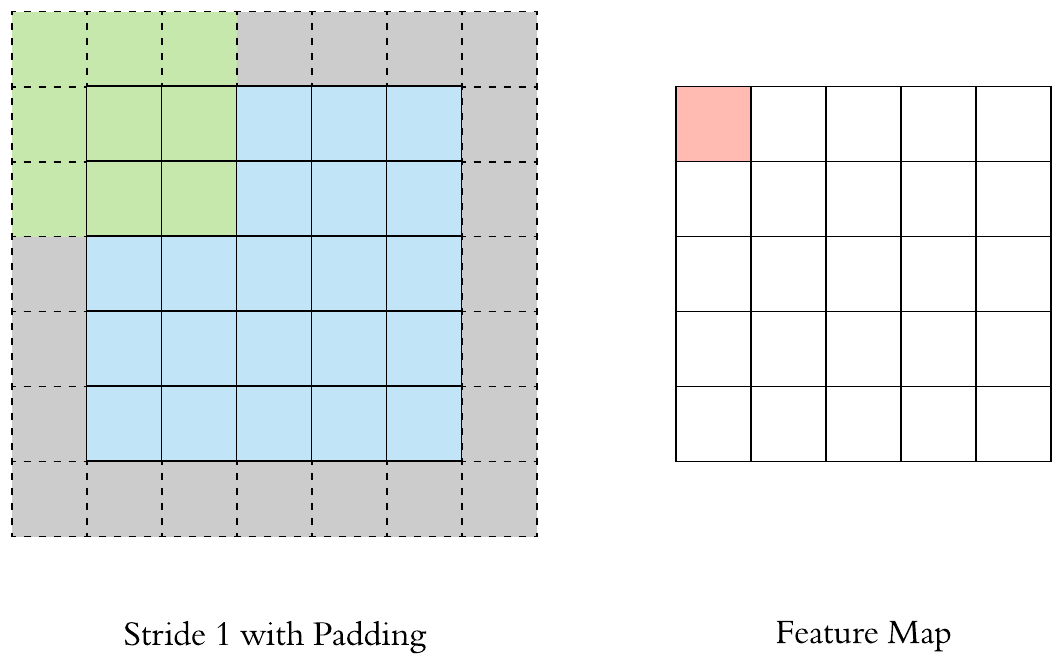

In [0]:
from IPython.display import Image
Image('/content/gdrive/My Drive/Colab_Notebooks/keras_study/padding.png', width=500)

**합성곱 스트라이드 이해하기**

출력 크기에 영향을 미치는 다른 요소는 **스트라이드**입니다. 지금까지는 합성곱 윈도우의 중앙 타일이 연속적으로 지나간다고 가정한 것입니다. 두 번의 연속적인 윈도우 사이즈의 거리가 스트라이드입니다. 

스트라이드 합성곱은 실전에서 드물게 사용되지만 모델에 따라 유용한 방법이므로 알아두어야 합니다. 다운샘플링하기 위해서는 스트라이드 대신에 최대 풀링 연산을 사용하는 경우가 많습니다.

**최대 풀링 연산**

앞의 컨브넷 예제에서 특성 맵의 크기가 MaxPooling2D 층마다 절반으로 줄어들었습니다. 최대 풀링 연산은 이처럼 특성 맵을 강제적으로 다운 샘플링하는 것입니다. 최대 풀링은 입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 채널별로 최댓값을 출력합니다.

사실 여기까지는 합성곱 스트라이드와 큰 차이가 없다고 생각할 수 있습니다. 하지만 합성곱은 추출한 패치에서 학습된 선형 변환(합성곱 커널)을 적용하는 대신 하트코딩된 최댓값 추출 연산을 사용합니다. 그림을 보면 이해가 될 것 같습니다.

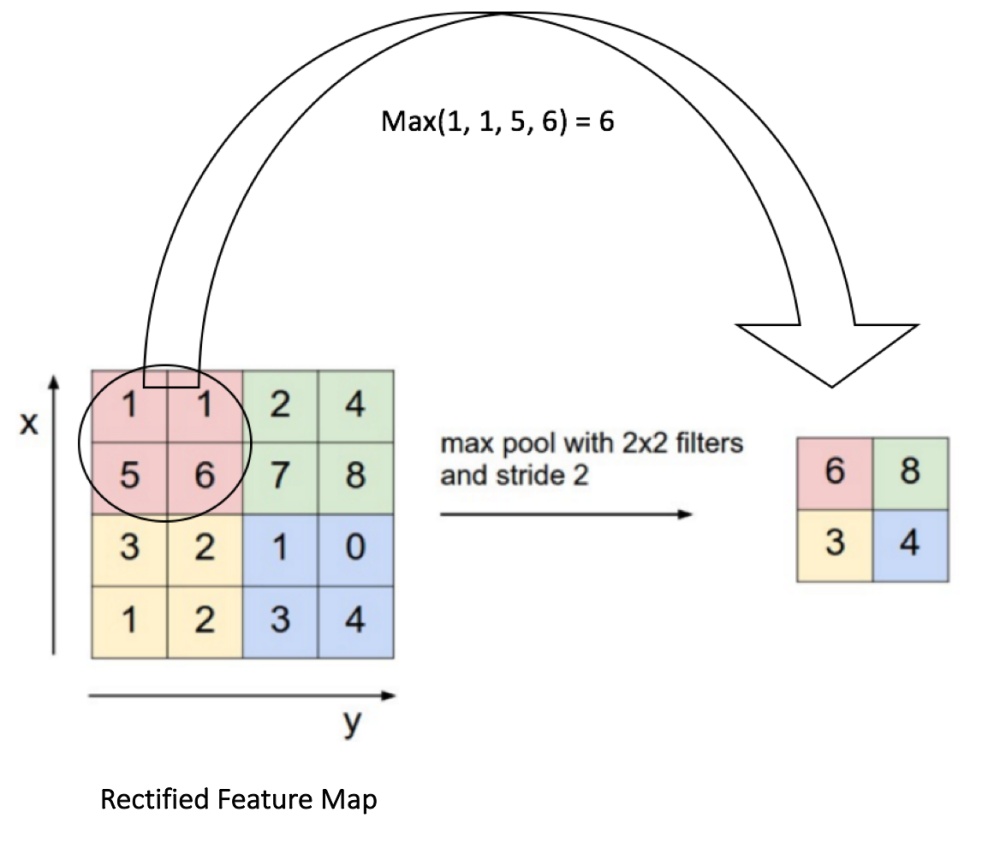

In [0]:
from IPython.display import Image
Image('/content/gdrive/My Drive/Colab_Notebooks/keras_study/maxpooling.png', width=500)

가장 큰 차이점은 최대풀링은 2 * 2 윈도우와 스트라이드 2를 사용하고, 합성곱은 3 * 3 윈도우와 스트라이드 1을 사용합니다. 왜 합성곱만 이용하지 않고, 최대 풀링 층을 이용할까요? 그 이유는 다음과 같이 설명할 수 있습니다.

* 합성곱 층으로만 이루어진 네트워크는 특성의 공간적 계층 구조를 학습하는데 도움이 되지 않습니다. 합성곱을 하며 줄어든 윈도우는 특성에 대한 정보가 부족합니다.
* 최종 가중치가 너무 많아 작은 모델에 비해 오버피팅이 발생할 가능성이 큽니다.
간단하게 다운샘플링의 이유는 특성 맵의 가중치 개수를 줄이는 것입니다. 또한 점점 커진 윈도우를 통해 입력 데이터를 공간적 계층 구조로 확인하기 위하여 사용합니다.

**평균 풀링(average pooling)** 도 이용할 수 있지만, 최대 풀링이 다른 방법보다 더 잘 작동하는 편입니다. 그 이유는 특성이 특성 맵의 각 타일에 따라서 어떤 패턴이나 개념의 존재 여부를 인코딩하는 경향이 있기 때문입니다. 그렇기에 합리적인, 납득할만한 서브샘플링(subsampling) 전략은 먼저 스트라이드 없는 합성곱으로 조밀한 특성 맵을 만들고, 최대 풀링 연산으로 최대 활성화된 특성을 고르는 것입니다.

## 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

실제로 이미지 분류 문제를 풀어보겠습니다.
* 적은 데이터 사용('적은'샘플 = 수백 ~ 수만개)
* 4,000개의 강아지와 고양이 사진(각 2,000개씩)
* 훈련 데이터 2,000개
* 검증과 테스트에 각 1,000개

문제를 해결하기 위한 기본적인 전략입니다.
* 보유한 소규모  데이터셋을 사용하여 처음부터 새로운 모델을 훈련
* 사전 훈련된 네트워크로 특성을 추출
* 사전 훈련된 네트워크를 세밀하게 튜닝

### 5.2.1 작은 데이터셋 문제에서 딥러닝의 타당성

딥러닝은 데이터가 풍부할 때만 작동한다는 말을 듣습니다. 부분적으로는 맞습니다. 하지만 많은 샘플이 의미하는 것은 상대적입니다. 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만 사용해서 훈련하는 것은 불가능합니다. 하지만 모델이 작고 규제가 잘 되어 있으며 간단한 작업이라면 가능합니다.

컨브넷은 지역적이고 평행 이동으로 변하지 않는 특성을 학습하기 때문에 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않고 컨브넷을 처음부터 훈련해도 납득할 만한 결과를 만들 수 있습니다. 특히 컴퓨터 비전에서는 사전 훈련된 모델들이 내려받을 수 있도록 많이 공개되어 있어서 매우 적은 데이터에서 강력한 모델을 만들 수 있습니다.

### 5.2.2 데이터 내려받기

여기서 사용할 강아지 vs 고양이 데이터셋은 케라스에 포함되어 있지 않아 캐글에서 받을 수 있습니다. 이 사진들은 중간 정도의 해상도를 가진 컬러 JPEG 파일입니다.

2013년, 본 데이터를 사용한 경연에서 우승자는 컨브넷을 사용했습니다. 최고 성능은 95%의 정확도를 달성했습니다. 책에서는 10%보다 적은 양으로 훈련하고도 근접한 정확도를 달성합니다.

캐글에는 별도의 테스트 데이터가 있지만 책에서는 완전한 예제를 구성하기 위해 훈련 데이터에서 훈련, 검증, 테스트 세트를 만듭니다. 

저는 코랩을 사용하기 때문에 kaggle API로 데이터셋을 받았습니다.

In [0]:
# 코드 5-4 훈련, 검증, 테스트 폴더로 이미지 복사하기
import os, shutil

#원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './cats_and_dogs_small'
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다.
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)
  
# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)

복사가 잘 되었는지 확인해 봅니다.

In [14]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))

print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))

print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


이제 2,000개의 훈련 이미지, 1,000개의 검증 이미지, 1,000개의 테스트 이미지가 준비되었습니다.

### 5.2.3 네트워크 구성하기

이전 MNIST보다 이미지가 크고 복잡하기 때문에 네트워크를 크게 만듭니다. 150x150 크기의 입력(임의로 선택한 크기)으로 시작해서 Flatten 층 이전에 7x7 크기의 특성 맵으로 줄어듭니다.

In [0]:
# 코드 5-5 강아지 vs. 고양이 분류를 위한 소규모 컨브넷 만들기
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
# 코드 5-6 모델의 훈련 설정하기
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

### 5.2.4 데이터 전처리

데이터는 네트워크에 주입되기 전에 부동 소수 타입의 텐서로 적절하게 전처리 되어 있어야 합니다. 데이터가 JPEG 파일이므로 다음 과정을 따릅니다.
1. 사진 파일을 읽습니다.
2. JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다.
3. 그다음 부동 소수 타입의 텐서로 변환합니다.
4. 픽셀값(0~255)의 스케일을 [0, 1]사이로 조정합니다.

케라스는 이런 단계를 자동으로 처리하는 유틸리티가 있습니다. 또한 케라스에는 ```keras.preprocessing.image```에 이미지 처리를 위한  헬퍼 도구들도 있습니다. ```ImageDataGenerator``` 클래스는 디스크에 있는 이미지 파일을 전처리된 배치 텐서로 자동으로 바꾸어 주는 파이썬 제네레이터를 만들어 줍니다.

In [0]:
# 코드 5-7 ImageDataGenerator를 사용하여 디렉터리에서 이미지 읽기
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,               # 타깃 디렉터리
                                                    target_size=(150, 150),  # 모든 이미지를 150x150 크기로 바꿉니다.
                                                    batch_size=20,
                                                    class_mode='binary')     # binary_crossentropy 손실을 사용하기 때문에 이진 레이블이 필요합니다.

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

제네레이터를 사용한 데이터에 모델을 훈련시켜 보겠습니다. ```fit_generator``` 메서드는 ```fit``` 메서드와 동일하되 제네레이터를 사용할 수 있습니다.

In [19]:
# 코드 5-8 배치 제네레이터를 사용하여 모델 훈련하기
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,                 # 데이터가 끝없이 생성되기 때문에 필요한 하나의 에포크 별 배치 개수
                                                                   # iterator 개념과 동일하다고 생각하면 됩니다. 제네레이터 배치:20 이므로 100개를 해야 2000개 데이터 사용
                              epochs=30,                           
                              validation_data=validation_generator,
                              validation_steps=50)                 # 검증 제네레이터 배치:20 이므로 50개를 해야 1000개 데이터 사용

W0827 02:49:49.668840 140373169182592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
100/100 [==============================] - 16s 155ms/step - loss: 0.6895 - acc: 0.5370 - val_loss: 0.6668 - val_acc: 0.6260
Epoch 2/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6614 - acc: 0.6090 - val_loss: 0.6654 - val_acc: 0.5860
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6215 - acc: 0.6760 - val_loss: 0.6215 - val_acc: 0.6480
Epoch 4/30
100/100 [==============================] - 9s 90ms/step - loss: 0.5802 - acc: 0.7055 - val_loss: 0.6774 - val_acc: 0.6260
Epoch 5/30
100/100 [==============================] - 9s 90ms/step - loss: 0.5416 - acc: 0.7165 - val_loss: 0.5727 - val_acc: 0.6860
Epoch 6/30
100/100 [==============================] - 9s 90ms/step - loss: 0.5102 - acc: 0.7445 - val_loss: 0.5813 - val_acc: 0.6860
Epoch 7/30
100/100 [==============================] - 9s 90ms/step - loss: 0.4813 - acc: 0.7620 - val_loss: 0.5467 - val_acc: 0.7130
Epoch 8/30
100/100 [==============================] - 9s 91ms/step 

코랩에서 돌리면 에포크별 약 9.90초 정도 소요됩니다. 훈련이 끝나면 항상 모델을 저장하는 것이 좋은 습관이라고 되있으니 앞으로 모델 저장을 생활화합시다^^

In [0]:
# 코드 5-9 모델 저장하기
model.save('cats_and_dogs_small_1.h5')

이제 훈련 데이터와 검증 데이터에 대한 모델의 손실과 정확도를 그래프로 그려보겠습니다.

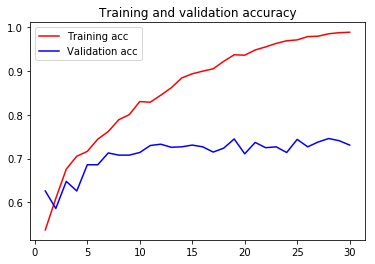

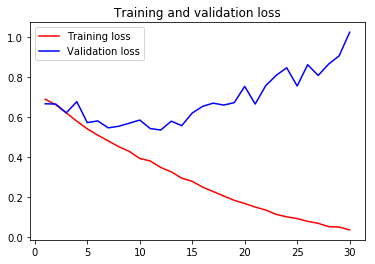

In [22]:
# 코드 5-10 훈련의 정확도와 손실 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프에서 훈련 정확도는 거의 100%에 도달하지만 검증 정확도는 70% 정도에서 멈추었습니다. 손실을 보면 검증 손실은 5 ~ 6 에포크 이후 더 이상 내려가지 않습니다. 비교적 훈련 샘플의 수가 적기 때문에 오버피팅이 가장 중요한 문제입니다. 드롭아웃이나 가중치 감소(L2 규제) 등 여러 가지 기법이 있지만 컴퓨터 비전에 특화되어 있는 **데이터 증식(data augmentation)** 을 시도하겠습니다.

### 5.2.5 데이터 증식 사용하기

데이터 증식은 기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러 가지 랜덤한 변환을 적용하여 샘플을 늘립니다. 모델이 데이터의 여러 측면을 학습하면 일반화에 도움이 될 것입니다.

케라스에서는 ```ImageDataGenerator```가 읽은 이미지에 여러 종류의 랜덤 변환을 적용하도록 설정할 수 있습니다.

In [0]:
# 코드 5-11 ImageDataGenerator를 사용하여 데이터 증식 설정하기
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest')

* ```rotation_range```는 랜덤하게 사진을 회전시킬 각도 범위입니다(0~180).
* ```width_shift_range```와 ```height_shift_range```는 사진을 수평과 수직으로 랜덤하게 평행 이동 시킬 범위입니다(전체 너비와 높이에 대한 비율).
* ```shear_range```는 랜덤하게 전단 변환을 적용할 각도 범위입니다.(회전할 때 y축 방향으로 각도를 증가시켜서 변형)
* ```zoom_range```는 랜덤하게 사진을 확대할 범위입니다.
* ```horizontal_flip```은 랜덤하게 이미지를 수평으로 뒤집습니다. 수평 대칭을 가정할 수 있을 때 사용합니다.
* ```fill_mode```는 회전이나 가로/세로  이동으로 인해 새롭게 생성해야 할 픽셀을 채울 전략입니다.

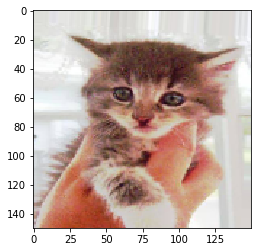

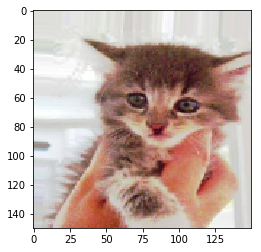

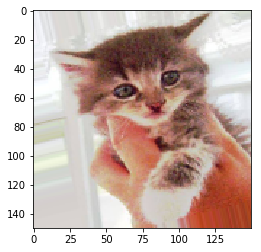

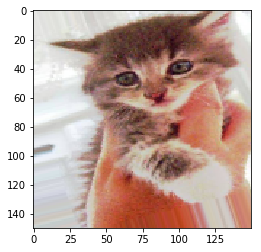

In [24]:
# 코드 5-12 랜덤하게 증식된 훈련 이미지 그리기
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

# 증식할 이미지를 선택합니다.
img_path = fnames[3]

# 이미지를 읽고 크기를 변경합니다.
img = image.load_img(img_path, target_size=(150, 150))

# (150, 150, 3) 크기의 넘파이 배열로 변환합니다.
x = image.img_to_array(img)
# (1, 150, 150, 3) 크기로 변환합니다.
x = x.reshape((1,) + x.shape)

# 랜덤하게 변환된 이미지 배치를 생성합니다. 무한 반복되기 때문에 어느 지점에서 중지해야 합니다.
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
    
plt.show()

데이터 증식을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두 번 주입되지 않습니다. 하지만 적은 수의 원본 이미지에서 만들어졌기 때문에 아직은 입력 데이터들 사이에 상호 연관성이 큽니다.

그렇기 때문에 오버피팅을 제거하기에 충분하지 않을 수 있습니다. 오버피팅을 억제하기 위해 완전 연결 층 이전에 dropout 층을 추가합니다.

In [0]:
# 코드 5-13 드롭아웃을 포함한 새로운 컨브넷 정의하기
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

데이터 증식과 드롭아웃을 사용하여 네트워크를 훈련시켜 봅니다.

In [26]:
# 코드 5-14 데이터 증식 제네레이터를 사용하여 컨브넷 훈련하기
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,  
                                                    target_size=(150, 150), # 모든 이미지를 150 × 150 크기로 바꿉니다
                                                    batch_size=32,
                                                    class_mode='binary')    # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 31s 308ms/step - loss: 0.6929 - acc: 0.5094 - val_loss: 0.6828 - val_acc: 0.5692
Epoch 2/100
100/100 [==============================] - 27s 275ms/step - loss: 0.6770 - acc: 0.5784 - val_loss: 0.6589 - val_acc: 0.5915
Epoch 3/100
100/100 [==============================] - 28s 277ms/step - loss: 0.6644 - acc: 0.5900 - val_loss: 0.6498 - val_acc: 0.6053
Epoch 4/100
100/100 [==============================] - 28s 278ms/step - loss: 0.6443 - acc: 0.6241 - val_loss: 0.6398 - val_acc: 0.6173
Epoch 5/100
100/100 [==============================] - 28s 283ms/step - loss: 0.6311 - acc: 0.6350 - val_loss: 0.6087 - val_acc: 0.6504
Epoch 6/100
100/100 [==============================] - 29s 289ms/step - loss: 0.6122 - acc: 0.6728 - val_loss: 0.6122 - val_acc: 0.6553
Epoch 7/100
100/100 [==============================] - 29s 286ms/step - loss: 0.6099 - acc: 0.6606 -

이번엔 에포크별 약 29초 정도 걸렸습니다... 오래걸렸지만 그래도 공짜로 GPU 쓸 수 있는것에 감사합니다....ㅎ

까먹지말고 모델을 저장합시다.

In [0]:
# 코드 5-15 모델 저장하기
model.save('cats_and_dogs_small_2.h5')

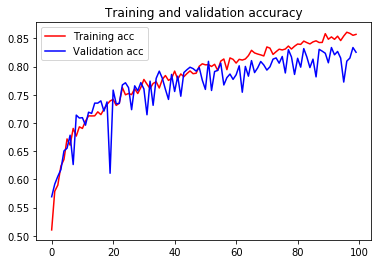

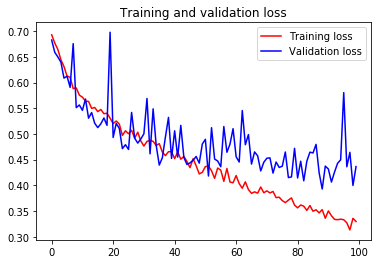

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

데이터 증식과 드롭아웃 덕분에 정확도가 많이 향상되었습니다. 약 80~85%정도 정확도를 달성했습니다.

다른 규제 기법을 더 사용하고 네트워크의 파라미터를 튜닝하면 더 높은 정확도를 얻을 수 있습니다. 하지만 데이터가 적기 때문에 컨브넷을 처음부터 훈련해서 더 높은 정확도를 달성하기는 어렵습니다. 이런 상황에서 정확도를 높이기 위한 다음단계는 사전 훈련된 모델을 사용하는 것입니다.